In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import argparse
import helpers
import networkx as nx
import numpy as np
import os

from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from networkx.algorithms.distance_measures import diameter
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier

In [6]:
def run_logistic(A, y, param, logging=False):
    m = DecentralizedSGDLogistic(**param)
    list_losses = m.fit(A, y, logging=logging)
    if logging:
        print()
        print('Final score: {0:.4f}'.format(m.score(A, y)))
    return list_losses

### Load Higgs Boson dataset

In [7]:
y, A = helpers.load_data()

### Compute the baseline with SGD classifier 

In [8]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A.shape[0], tol=1e-4, n_jobs=1, random_state=2)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.7444
Final loss: 0.5063267378689561


### Computing with Decentralized SGD

In [9]:
reg = 1 / A.shape[0]
n_features = A.shape[1]
compute_loss_every = 10
params_disconnected = dict(num_epoch=15, lr_type='bottou',
                           initial_lr=0.05, tau=n_features, regularizer=reg,
                           quantization='full', n_machines=2048,
                           method='plain', topology='disconnected', estimate='final',
                           split_data_random_seed=2, distribute_data=True,
                           split_data_strategy='naive', 
                           compute_loss_every=compute_loss_every, tol=1e-10)

In [20]:
reg = 1 / A.shape[0]
n_features = A.shape[1]
compute_loss_every = 5

params = dict(num_epoch=15, lr_type='bottou',
                           initial_lr=0.05, regularizer=reg,
                           quantization_method='full', n_machines=8100,
                           communication_method='plain',
                           data_distribution_random_seed=2, random_seed=2,
                           data_distribution_strategy='random', 
                           compute_loss_every=compute_loss_every, tol=1e-10)

### Real Social Network Graph

In [21]:
G = nx.read_gml('power.gml', label=None)
G = G.to_undirected()

print("number of nodes " + str(G.number_of_nodes()))
print("number of edges " + str(G.number_of_edges()))

number of nodes 4941
number of edges 6594


#### Compute the losses of complete topology

In [22]:
params_complete = params.copy()
params_complete['topology'] = 'complete'
params_complete['n_machines'] = G.number_of_nodes()
losses_complete = run_logistic(A, y, params_complete, logging=True)

Epoch      Iteration      Time      Loss      Accuracy      
[1/15]     [50/50]        20s       0.6036    0.7071        
[2/15]     [50/50]        40s       0.5899    0.7110        
[3/15]     [50/50]        60s       0.5846    0.7129        
[4/15]     [50/50]        80s       0.5815    0.7143        
[5/15]     [50/50]        100s      0.5792    0.7156        
[6/15]     [50/50]        120s      0.5774    0.7167        
[7/15]     [50/50]        139s      0.5759    0.7180        
[8/15]     [50/50]        161s      0.5746    0.7188        
[9/15]     [50/50]        178s      0.5735    0.7197        
[10/15]    [50/50]        194s      0.5724    0.7203        
[11/15]    [50/50]        210s      0.5716    0.7209        
[12/15]    [50/50]        229s      0.5708    0.7215        
[13/15]    [50/50]        246s      0.5701    0.7218        
[14/15]    [50/50]        264s      0.5695    0.7225        
[15/15]    [50/50]        281s      0.5690    0.7228        

Final score: 0.7228


#### Compute the losses of real network topology

In [23]:
params_real = params.copy()
params_real['topology'] = nx.adjacency_matrix(G).toarray()
params_real['n_machines'] = G.number_of_nodes()
losses_real = run_logistic(A, y, params_real, logging=True)

Epoch      Iteration      Time      Loss      Accuracy      
[1/15]     [50/50]        19s       0.6025    0.7065        
[2/15]     [50/50]        36s       0.5896    0.7104        
[3/15]     [50/50]        54s       0.5866    0.7123        
[4/15]     [50/50]        71s       0.5867    0.7137        
[5/15]     [50/50]        90s       0.5870    0.7153        
[6/15]     [50/50]        108s      0.5878    0.7166        
[7/15]     [50/50]        125s      0.5893    0.7172        
[8/15]     [50/50]        143s      0.5900    0.7182        
[9/15]     [50/50]        162s      0.5901    0.7192        
[10/15]    [50/50]        179s      0.5905    0.7201        
[11/15]    [50/50]        197s      0.5907    0.7209        
[12/15]    [50/50]        215s      0.5900    0.7215        
[13/15]    [50/50]        233s      0.5896    0.7224        
[14/15]    [50/50]        250s      0.5895    0.7229        
[15/15]    [50/50]        268s      0.5889    0.7234        

Final score: 0.7234


## Plots of results

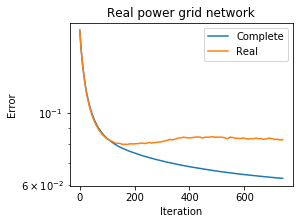

In [24]:
iterations_indices = np.arange(0, losses_real.shape[0] * compute_loss_every, 
                               compute_loss_every)
plot_losses(np.stack((losses_complete[:-1], losses_real[:-1])),
            iterations_indices[:-1], optimum_loss=optimum_loss,
            labels=["Complete","Real"], title="Real power grid network", 
            figsize=(4,3), save_as_pdf=True, pdf_name="real_net")